In [1]:
%load_ext autotime

time: 145 µs (started: 2023-12-08 18:18:18 +01:00)


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

time: 7.37 ms (started: 2023-12-08 18:18:18 +01:00)


In [3]:
# import modin.pandas as pd
# import swifter

import glob
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)

time: 562 ms (started: 2023-12-08 18:18:18 +01:00)


In [4]:
from numba import jit, njit, vectorize, guvectorize, prange
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()
num_cores

256

time: 270 ms (started: 2023-12-08 18:18:18 +01:00)


In [5]:
from mie_icon_art import *
from aop import *

2023-12-08 18:18:19.976982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 18:18:20.085649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-08 18:18:20.085676: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-08 18:18:21.048905: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

time: 3.36 s (started: 2023-12-08 18:18:18 +01:00)


In [6]:
class MieAI():
    def __init__(self, data, wavelength, mode='acc', 
                 core=['ash'], shell=['h2o', 'so4', 'nh4', 'no3'], soot='ash',
                 model = '/work/bb1070/b382177/mie/icon/17-08-2023/model/model_17-08-2023.h5',
                 fscale = "/work/bb1070/b382177/mie/icon/05-07-2023/model/mlp_min_max.csv",
                 qt_model = '/work/bb1070/b382177/mie/icon/17-08-2023/model/transformer_17-08-2023.pkl',
                 nbins=15, verbose=1, ncpus=10):
        self.data = data
        self.mode = mode
        self.nbins = nbins
        self.wavelength = wavelength
        self.core = core
        self.shell = shell
        self.soot = soot
        self.fscale = fscale
        self.qt_model = qt_model
        self.qt = joblib.load(self.qt_model)
        self.scale = pd.read_csv(self.fscale, names=['col', 'max', 'min'], skiprows=[0]).set_index('col') 
        self.model = tf.keras.models.load_model(model)
        self.verbose = verbose
        self.ncpus = ncpus
        print('Running MieAI on mode: %s'%self.mode)
        
    def preprocess(self):
        self.n, self.k = load_indices(lam=self.wavelength)
        self.input, self.coat = prepare(self.data, self.n, self.k, lam=self.wavelength, mode=self.mode, core=self.core, shell=self.shell, soot=self.soot)
        self.input['coating'] = self.coat.rename({'height':'height_2'})
        self.input['med_diam'] = self.data['diam_mixed_%s'%self.mode]
        self.input['x'] = 1e6 * np.pi * self.data['diam_mixed_%s'%self.mode] / self.wavelength
        self.input = self.input.squeeze().rename({'real_core':'n_core', 'imag_core':'k_core', 'real_shell':'n_shell', 'imag_shell':'k_shell'})
        return self.input 
    
    def get_aod(self):
        modes = self.data.icon.get_modes(mode_type='mixed_%s'%self.mode)[1:-1]
        conc = self.data[modes].to_array(dim='species').sum(dim='species')        
        const = (self.data.icon3.dz * self.data['rho'] * conc * 1e-6).squeeze()
        inp = self.preprocess()
        ext = self.get_aop(inp).isel(aop=0).squeeze()
        aod = (ext*const).integrate('height_2')
        aod.name = 'mixed_%s_aod'%self.mode
        return aod
    
    def get_aop(self, xx):
        ext = np.zeros((len(xx.ncells), 4, len(xx.height_2)))         
        for h in np.arange(len(xx.height_2)):
            if self.verbose:
                print('Working on level %s'%h)
            ext[:, :, h] = self.emulate(xx.isel(height_2=h))           
        ext = xr.DataArray(ext, dims=['ncells', 'aop', 'height_2'], coords=[xx.ncells, ['ext', 'sca', 'ssa', 'asy'], xx.height_2])
        return ext
    
    def emulate(self, df):        
        out_col = ["Extinction", "Scattering", "Asym"]
        cols = ['coating', 'x', 'n_core', 'k_core', 'n_shell', 'k_shell', 'lambda']
        gcols = ['tdia', 'pdf', 'dlogd', 'area', 'ncells', 'vol', 'const', 'scats', "Extinction", "Scattering", "Asym"]
        
        nn = len(self.data.ncells)
        opt = np.empty((nn, 4)) 
        
        df1 = df.to_pandas().drop('time', axis=1)
        cnames = df1.columns
        inp = df1.med_diam.values
        df1 = df1.values

        szs = mod2bin2(df1, inp)
        
        df = np.repeat(df1, repeats=15, axis=0)
        df = pd.DataFrame(df, columns=cnames)
        
        df['pdf'] = szs[:, 0]
        df['dia'] = szs[:, 1] * 1e9
        df['dlogd'] = szs[:, 2]

        df['tdia'] = df['dia'] * (1 + df.coating)
        df['area'] = (np.pi / 4) * (df['dia']**2)
        df['ncells'] = df.index        
        df['lambda'] = self.wavelength
     
        df1 = self.scale.loc[cols, :]
        df2 = self.scale.loc[out_col, :]        
        dfx = (df[cols] - df1['min']) / (df1['max'] - df1['min'])

        start = time.time()
        pred1 = self.model.predict(dfx, verbose=0, batch_size=50000, use_multiprocessing=True, workers=self.ncpus)
        #data_chunks = np.array_split(dfx, self.ncpus)
        #pred1 = np.concatenate(Parallel(n_jobs=self.ncpus)(delayed(self.model.predict)(chunk) for chunk in data_chunks))
        end = time.time()
        print('Elapsed time in emulation: %s'%(end - start))
        pred1 = self.qt.inverse_transform(pred1)

        y1 = pd.DataFrame(pred1, columns=out_col, index=dfx.index)
        y1 = (df2['max'][out_col] - df2['min'][out_col]) * y1 + df2['min'][out_col]
        df[out_col] = y1[out_col]
        
        df['vol'] = (np.pi / 6) * (df['tdia']**3) * df['pdf'] * df['dlogd']
        df['const'] = df['area'] * df['pdf'] * df['dlogd'] 
        df['scats'] = df["Scattering"] * df['const'] 
            
        arr = df[gcols].values 
        q2k(arr, opt)
        return opt

time: 3.15 ms (started: 2023-12-08 18:18:22 +01:00)


In [7]:
mode_name = {'ait':'aitken', 'acc':'accumulation', 'coa':'coarse'}

time: 19.6 ms (started: 2023-12-08 18:18:22 +01:00)


In [8]:
dxx = 0.05
lam = 0.55  

latmin = -20
latmax = 20

lonmin = -180
lonmax = 180

lon_vec = np.arange(lonmin, lonmax, dxx)
lat_vec = np.arange(latmin, latmax, dxx)

time: 2.5 ms (started: 2023-12-08 18:18:22 +01:00)


In [9]:
gridfile = '/scratch/b/b380982/ICON-OUTPUT/6_Gnu_Age/iconR2B06_DOM01.nc'
filename = '/work/bb1070/b380982/Gnu_PermaStrom/5_Gnu_Age/icon-art-aging-aero_DOM01_ML_0012.nc'
filename

'/work/bb1070/b380982/Gnu_PermaStrom/5_Gnu_Age/icon-art-aging-aero_DOM01_ML_0012.nc'

time: 7.95 ms (started: 2023-12-08 18:18:22 +01:00)


In [10]:
dx = xr.open_dataset(filename)
dg = get_dataset_grid(gridfile)
al = dx.icon.get_modes(mode_type='mixed_') + ['rho', 'z_ifc']
dx = xr.merge([dx[al], dg])

sel_index = (dx.ncells).where((dx.clon>lonmin) & (dx.clon<lonmax) & (dx.clat>latmin) & (dx.clat<latmax), drop=True)
sel_index = sel_index.astype(int)
dx = dx.isel(ncells=sel_index)
dx

<xarray.Dataset>
Dimensions:         (time: 1, height_2: 90, ncells: 110773, height: 91, nv: 3)
Coordinates:
  * height          (height) float64 1.0 2.0 3.0 4.0 5.0 ... 88.0 89.0 90.0 91.0
  * height_2        (height_2) float64 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
  * time            (time) datetime64[ns] 2019-06-25T12:00:00
    clat            (ncells) float64 -19.81 -19.94 -19.75 ... -19.88 -19.95
    clon            (ncells) float64 76.91 76.65 76.34 ... 66.49 66.53 65.96
Dimensions without coordinates: ncells, nv
Data variables: (12/32)
    nmb_mixed_ait   (time, height_2, ncells) float32 ...
    nmb_mixed_acc   (time, height_2, ncells) float32 ...
    nmb_mixed_coa   (time, height_2, ncells) float32 ...
    dust_mixed_acc  (time, height_2, ncells) float32 ...
    dust_mixed_coa  (time, height_2, ncells) float32 ...
    na_mixed_acc    (time, height_2, ncells) float32 ...
    ...              ...
    diam_mixed_coa  (time, height_2, ncells) float32 ...
    rho             (time, height_2, ncells) float32 ...
    z_ifc           (height, ncells) float32 ...
    cell_area       (ncells) float64 ...
    clon_vertices   (ncells, nv) float64 76.92 77.21 76.64 ... 65.95 66.22 65.66
    clat_vertices   (ncells, nv) float64 -20.11 -19.71 -19.64 ... -19.77 -19.85
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  24
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/ic...
    uuidOfHGrid:          9b0b03ca-18c4-11e4-9318-776f158edd08
    uuidOfVGrid:          7e75629f-e43a-8018-6e08-340e90b12ce0
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               https://b380956@gitlab.dkrz.de/icon/icon-kit.git@b2...
    history:              icon.exe at 20230503 171325
    references:           see MPIM/DWD publications
    comment:              Heike Vogel (b380982) on l20624 (Linux 4.18.0-348.e...

time: 208 ms (started: 2023-12-08 18:18:22 +01:00)


In [11]:
core = ['dust', 'soot', 'na', 'cl']
shell = ['h2o', 'so4', 'nh4', 'no3']

time: 279 µs (started: 2023-12-08 18:18:22 +01:00)


In [12]:
model = '/work/bb1070/b382177/mie/icon/17-08-2023/model/model_17-08-2023.h5'
fscale = "/work/bb1070/b382177/mie/icon/05-07-2023/model/mlp_min_max.csv"
qt_model = '/work/bb1070/b382177/mie/icon/17-08-2023/model/transformer_17-08-2023.pkl'

time: 22.7 ms (started: 2023-12-08 18:18:22 +01:00)


In [13]:
aod1 = MieAI(dx, lam, core=core, shell=shell, soot='soot', mode='acc', verbose=0).get_aod()
aod2 = MieAI(dx, lam, core=core, shell=shell, soot='soot', mode='coa', verbose=0).get_aod()
aod = (aod1 + aod2).icon3.regrid(lon_vec, lat_vec).interpolate_na(method='nearest', dim='Latitude')
aod.name = 'AOD550'

aod

Running MieAI on mode: acc


2023-12-08 18:18:22.702119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-12-08 18:18:22.702152: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-08 18:18:22.702167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (l40002.lvt.dkrz.de): /proc/driver/nvidia/version does not exist
2023-12-08 18:18:22.702390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Elapsed time in emulation: 0.8029780387878418
Elapsed time in emulation: 0.7301902770996094
Elapsed time in emulation: 0.6939129829406738
Elapsed time in emulation: 0.7013509273529053
Elapsed time in emulation: 0.8634443283081055
Elapsed time in emulation: 0.6491875648498535
Elapsed time in emulation: 0.7616016864776611
Elapsed time in emulation: 0.7698371410369873
Elapsed time in emulation: 0.6579983234405518
Elapsed time in emulation: 0.8486192226409912
Elapsed time in emulation: 0.7393703460693359
Elapsed time in emulation: 0.6809818744659424
Elapsed time in emulation: 0.6751341819763184
Elapsed time in emulation: 0.9181694984436035
Elapsed time in emulation: 0.6537621021270752
Elapsed time in emulation: 0.6806192398071289
Elapsed time in emulation: 0.6954474449157715
Elapsed time in emulation: 0.7578749656677246
Elapsed time in emulation: 0.6611297130584717
Elapsed time in emulation: 0.8960425853729248
Elapsed time in emulation: 0.7012085914611816
Elapsed time in emulation: 0.90671

<xarray.DataArray 'AOD550' (Latitude: 800, Longitude: 7200)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.024803  , 0.02467913,
        0.02453186],
       [       nan,        nan,        nan, ..., 0.02522647, 0.0251026 ,
        0.02497873],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * Longitude  (Longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * Latitude   (Latitude) float64 -20.0 -19.95 -19.9 -19.85 ... 19.85 19.9 19.95

time: 15min 37s (started: 2023-12-08 18:18:22 +01:00)


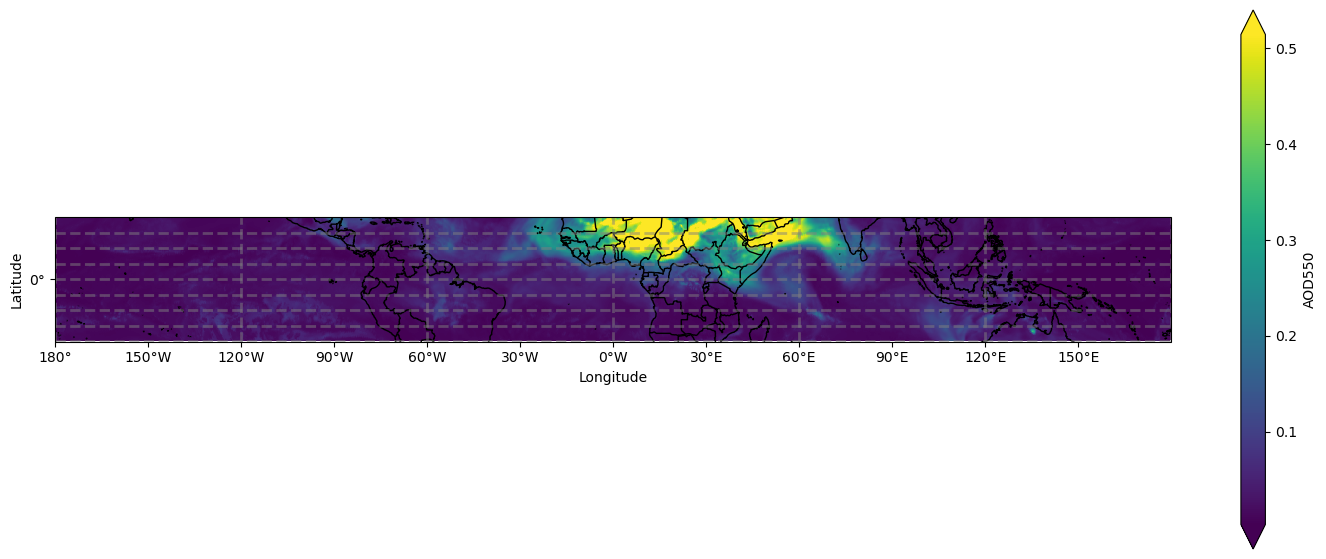

time: 10.3 s (started: 2023-12-08 18:34:00 +01:00)


In [14]:
ax = plt.axes(projection = ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)

# ax.set_xticks(np.arange(-180, 180, 10), crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-180, 180, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 30), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(-90, 90, 10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

fig = plt.gcf()
fig.set_size_inches(18, 7)

aod.plot(ax=ax, robust=True)

# plt.savefig('./figs/global_aod_mixed_dust.jpg', dpi=300, bbox_inches='tight')
plt.show()